EPI Correction

In [482]:
import numpy as np
import matplotlib.pyplot as plt

In [483]:
def imshow(i):
    plt.imshow(np.concatenate((np.real(i),np.imag(i)),axis=1))
    plt.colorbar()

In [484]:
delay_array = np.random.uniform(-0.8,0.8,(256,))

In [485]:
def kspace(size: int, drift: float, calibration: int) -> np.ndarray:
    #drift is the linear row-dependent delay (drift * ky)
    array = np.zeros((size,size),dtype=complex)
    for kx in range(256):
        for ky in range(256):
            measured_kx = kx + delay_array[ky]
            array[ky,kx] = np.sinc((measured_kx-128)/2)*np.sinc((calibration*(ky-128))/2)
    return array

In [486]:
calibration = kspace(256,0.5,0)
ifft = np.fft.ifftshift(np.fft.ifft(np.fft.fftshift(calibration), axis = 1))

Using atan2

In [488]:
angles = np.arctan2(np.imag(ifft),np.real(np.real(ifft)))
shifted_angles = np.roll(angles, shift = 1, axis = 1)
diff = angles - shifted_angles

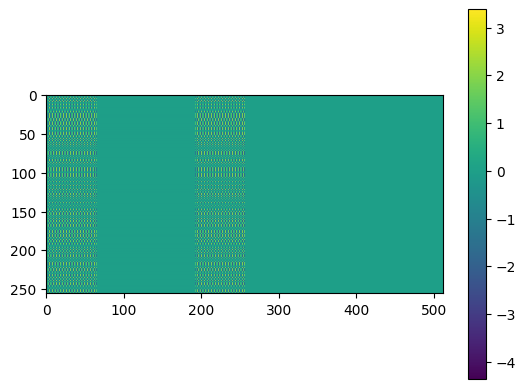

In [489]:
imshow(diff)

In [490]:
#There is an issue using arctan2 because of its implementation. Losing information when using arctan2 (losing magnitude).
#magnitude tells if meaningful angle as part of signal. It turns continuous values into discontinuous values (since it goes from -pi to pi).
#If it crosses negative axis in complex plane, it goes from -pi to pi, or other way around. These are problems with using atan2.

Using Complex Conjugate

In [491]:
#Complex conjugate squares the magnitude - this method is more robust when it comes to considering noise.

In [492]:
ifft_shifted = np.roll(ifft, shift = 1, axis = 1)
ifft_conj = np.conj(ifft_shifted)

In [493]:
complex_slope = np.multiply(ifft, ifft_conj)

row_sum = np.sum(complex_slope, axis = 1)

In [494]:
per_row_correction = np.arctan2(np.imag(row_sum),np.real(row_sum))

In [495]:
phase_ramp = np.exp(-1j*2*np.pi*per_row_correction)

In [496]:
correction = np.zeros((256,256),dtype=complex)
for kx in range(256):
    for ky in range(256):
        correction[ky,kx] = np.exp(-1j*(kx-128)*(per_row_correction[ky]))

In [497]:
fft_rows_corrected = ifft * correction

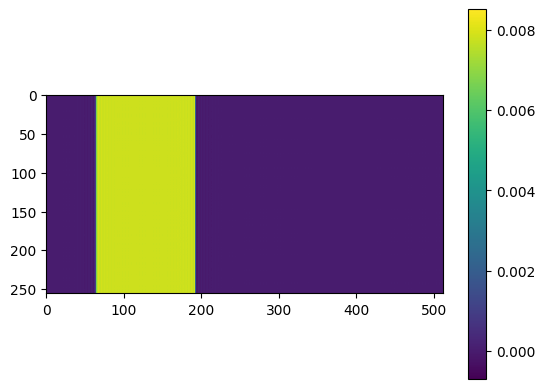

In [498]:
imshow(fft_rows_corrected)

In [499]:
badarray = kspace(256,0.5,1)

In [500]:
ifft = np.fft.ifftshift(np.fft.ifft(np.fft.fftshift(badarray), axis = 1))

TypeError: Invalid shape (2, 512, 256) for image data

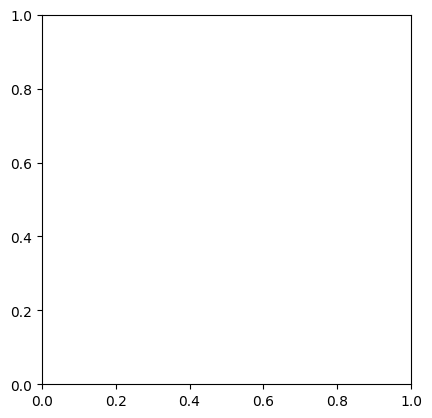

In [501]:
#zebra stripe pattern due to large shift in k-space which turned into a large phase ramp. 
#Atan2 method would be completely unreliable in this situation due to it being constrained between -pi and pi
imshow(ifft)

In [ ]:
corrected_array = np.multiply(ifft,correction)

In [ ]:
ifft_col = np.fft.ifftshift(np.fft.ifft(np.fft.fftshift(corrected_array), axis = 0))

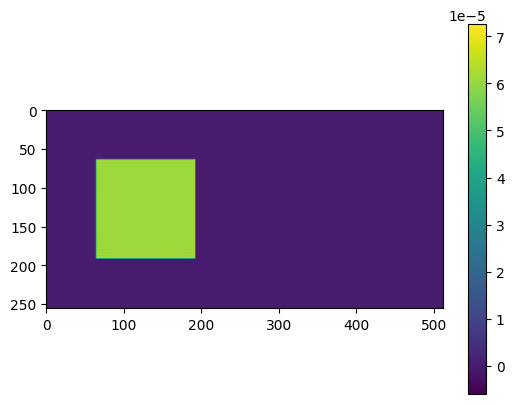

In [ ]:
#ghost caused by different amounts of ringing in different parts of k-space
imshow(ifft_col)

In [ ]:
ifft_bad = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(badarray)))

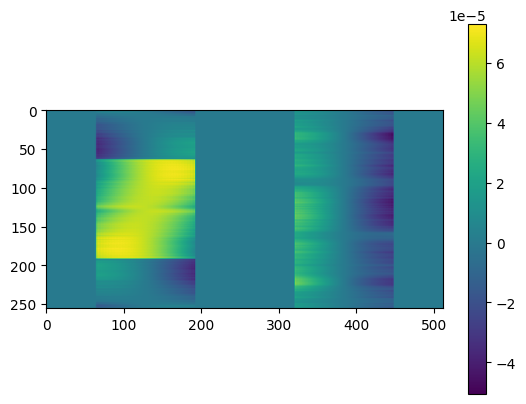

In [ ]:
imshow(ifft_bad)